In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

from sklearn.metrics import adjusted_rand_score
from more_itertools import flatten
from scipy.special import gammaln, digamma
from scipy.stats import gamma

In [2]:
## EXTRACT THE RELEVANT SIMULATION PARAMETERS
param_path = "analyses/simulation_studies/simulation_parameters/simulation_study_2"
with open(param_path + '/sim_params_simulation_study_2.json', 'r') as file:
    sim_params = json.load(file)

In [3]:
df_sim_params = pd.DataFrame(sim_params)
df_sim_params.columns = ['rate_matrices', 'rho_matrix', 'num_nodes', 'num_groups', 
                         'group_props', 'n_cavi', 'int_length', 'delta', 'T_max',
                         'change_steps_gap']

### Function for data extraction

In [27]:
def data_and_param_extract(idx, N_runs):
    ## LOAD RELEVANT DATA
    base_path = "analyses/simulation_studies/simulation_output/simulation_study_2/"

    output_dict = dict()

    ## alpha
    alpha_list = []
    for j in range(N_runs):
        file_path = base_path + f"alpha/alpha_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        alpha_list.append(data)

    ## beta
    beta_list = []
    for j in range(N_runs):
        file_path = base_path + f"beta/beta_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        beta_list.append(data)

    ## alpha
    gamma_list = []
    for j in range(N_runs):
        file_path = base_path + f"gamma/gamma_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        gamma_list.append(data)

    ## alpha
    tau_list = []
    for j in range(N_runs):
        file_path = base_path + f"tau/tau_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        tau_list.append(data)

    ## changes
    changes_list = []
    for j in range(N_runs):
        file_path = base_path + f"changes/changes_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        changes_list.append(data)

    output_dict['alpha'] = alpha_list
    output_dict['beta'] = beta_list
    output_dict['gamma'] = gamma_list
    output_dict['tau'] = tau_list
    output_dict['changes'] = changes_list

    ## EXTRACT THE RELEVANT SIMULATION PARAMETERS
    param_path = "analyses/simulation_studies/simulation_parameters/simulation_study_2"
    with open(param_path + '/sim_params_simulation_study_2.json', 'r') as file:
        sim_params = json.load(file)
        sim_params_curr = sim_params[idx]

    output_dict['rate_matrices'] = np.array(sim_params_curr[0])
    output_dict['rho_matrix'] = np.array(sim_params_curr[1])
    output_dict['num_nodes'] = int(sim_params_curr[2])
    output_dict['num_groups'] = int(sim_params_curr[3])
    output_dict['group_props'] = np.array(sim_params_curr[4])
    output_dict['n_cavi'] = int(sim_params_curr[5])
    output_dict['int_length'] = float(sim_params_curr[6])
    output_dict['delta'] = float(sim_params_curr[7])
    output_dict['T_max'] = float(sim_params_curr[8])
    output_dict['change_gap_steps'] = float(sim_params_curr[9])

    # Rate change times
    first_change = 3
    second_change = first_change + output_dict['change_gap_steps']  * output_dict['int_length'] 
    rate_change_times = np.array([first_change, second_change])
    output_dict['rate_change_times'] = rate_change_times

    ## CONSTRUCT TRUE GROUP LABELS
    group_sizes = (output_dict['group_props'] * output_dict['num_nodes']).astype('int')
    output_dict['group_sizes'] = group_sizes
    missing_nodes = output_dict['num_nodes'] - group_sizes.sum()
    if missing_nodes != 0:
        if np.sum(np.where(group_sizes == 0)) != 0:
            group_sizes[np.where(group_sizes == 0)] = missing_nodes
        else:
            group_sizes[-1] += missing_nodes
    true_groups = np.array(
                list(flatten([[i]*j for i,j in enumerate(group_sizes)]))
                )
    output_dict['groups'] = true_groups

    return output_dict


In [28]:
df_rates = pd.DataFrame(columns=['delta', 'first_change', 'second_change', 
                               'pred_change_times',
                               'conf_lower', 'conf_upper', 'mean'], index=range(12))

for sim in range(12):
    N_runs = 50
    data_dict = data_and_param_extract(sim, N_runs)
    df_rates.loc[sim, ['delta', 'first_change', 'second_change']] = (
        [data_dict['delta'], data_dict['rate_change_times'][0], 
         data_dict['rate_change_times'][1]]
    )
    alpha = np.array(data_dict['alpha'])
    beta = np.array(data_dict['beta'])
    gamma_dist = gamma(a = alpha, scale = 1 / beta)
    mean = gamma_dist.mean().mean(axis=0)
    lower = gamma_dist.ppf(0.025).mean(axis=0)
    upper = gamma_dist.ppf(0.975).mean(axis=0)

    df_rates.loc[sim, ['conf_lower', 'conf_upper', 'mean']] = lower, upper, mean

    df_rates.loc[sim,'pred_change_times'] = data_dict['changes']


In [5]:
def CCD_DNF(cps, group_k_m_changes, burn_in=2):
    # Temporarily drop flags pre-burn in
    group_k_m_changes = group_k_m_changes[group_k_m_changes > burn_in]
    cp_prev = 0
    tot_detect = len(group_k_m_changes)
    true_flags = 0
    false_flags = 0
    for cp_num, cp in enumerate(cps):
        # First cp
        if cp_num == 0:
            in_region = group_k_m_changes[(group_k_m_changes <= cp)]
            false_flags += len(in_region)
        else:
            in_region = group_k_m_changes[(group_k_m_changes > cp_prev) & (group_k_m_changes <= cp)]
            if len(in_region) != 0:
                true_flags += 1
                false_flags += (len(in_region) - 1)
        cp_prev = cp
    
    # Final cp
    in_region = group_k_m_changes[(group_k_m_changes > cp)]
    if len(in_region) != 0:
        true_flags += 1
        false_flags += (len(in_region) - 1)

    # print(f"True flags: {true_flags}")
    # print(f"False flags: {false_flags}")
    # print(f"True changes: {cps}")
    # print(f"Pred changes: {group_k_m_changes}")
    if (true_flags + false_flags) != tot_detect:
        raise ValueError("Number of true or false flags incorrect.")
    
    CCD = true_flags / len(cps)
    DNF = true_flags / tot_detect

    return CCD, DNF

In [29]:
burn_in = 2

# fig, axs = plt.subplots(2, 3, figsize=(12, 12))

T_max = data_dict['T_max']
int_length = data_dict['int_length']
second_change = df_rates['second_change'].unique().reshape((2,3))

CCD_arr = np.zeros((2, 6, 50))
DNF_arr = np.zeros((2, 6, 50))
row_count = -1
for delta in [0.1, 1]:
    row_count += 1
    col_count = -1
    for i in range(2):
        for j in range(3):
            col_count += 1
            CCD_list = []; DNF_list = []
            change_time = second_change[i,j]
            index = df_rates[
                        (df_rates['delta'] == delta)
                        &
                        (df_rates['second_change'] == change_time)
                        ].index[0]
            pred_changes_list = df_rates.loc[index, 'pred_change_times']
            if delta == 0.1:
                group_enum = 0
            else:
                group_enum = 5
            for k in range(2):
                for m in range(2):
                    if delta == 0.1:
                        group_enum += 1
                    else:
                        group_enum -= 1
                    for ell in range(50):
                        pred_changes = pred_changes_list[ell][:,[0,2,3]]
                        group_k_m_changes = pred_changes[
                            (pred_changes[:,1] == k) & (pred_changes[:,2] == m)
                            ][:,0]
                        group_k_m_changes = group_k_m_changes[group_k_m_changes > burn_in]
                        if group_enum == 4:
                            CCD_val, DNF_val = CCD_DNF([3, change_time], group_k_m_changes,
                                                    burn_in)
                            CCD_list.append(CCD_val); DNF_list.append(DNF_val)
            if len(CCD_list) != 0:
                CCD_arr[row_count, col_count, :] = CCD_list
            if len(DNF_list) != 0:
                DNF_arr[row_count, col_count, :] = DNF_list

In [30]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

colours = [(208/255, 28/255, 139/255),
           (241/255, 182/255, 218/255),
           (184/255, 225/255, 134/255),
           (77/255, 172/255, 38/255)]

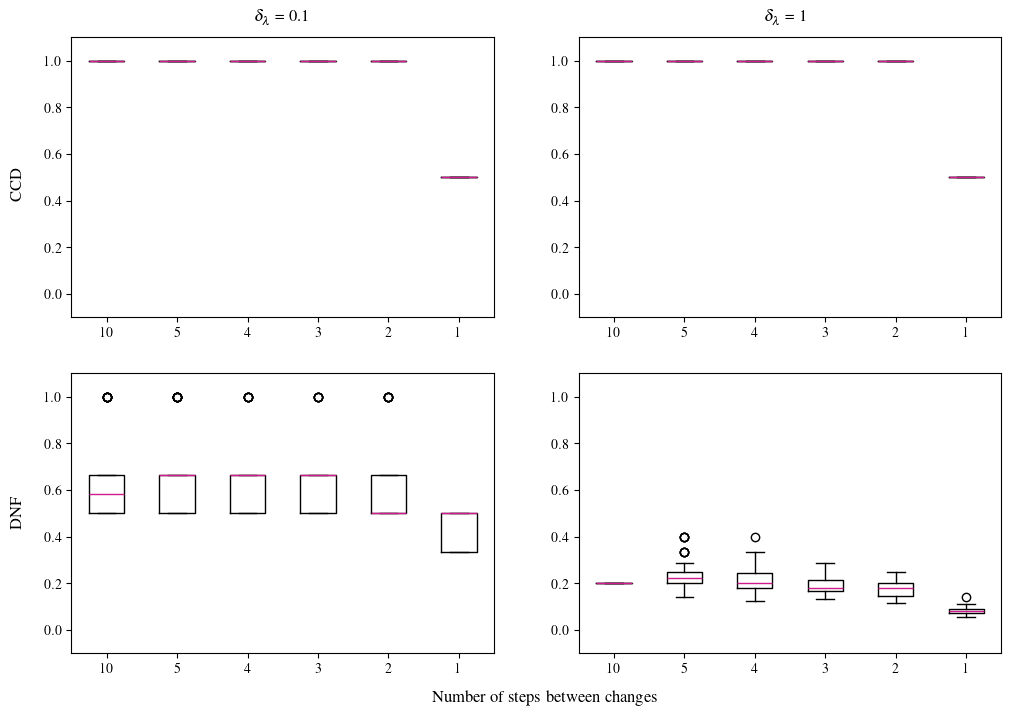

In [31]:
fig, axs = plt.subplots(2,2, figsize=(12,8))

gap_between_change = ((df_rates['second_change'].unique().astype('float') - 3) / 0.1).round().astype('int')

for i in range(2):
    for j in range(2):
        if i == 0:
            data = CCD_arr
        elif i == 1:
            data = DNF_arr
        axs[i,j].boxplot([data[j, gap, :] for gap in range(6)], positions=np.arange(6),
                          medianprops={'color': colours[0]})
        axs[i,j].set_xticklabels(gap_between_change)
        axs[i,j].set_ylim([-0.1,1.1])

fig.text(0.08, 0.68, 'CCD', ha='center', rotation='vertical', fontsize=12)
fig.text(0.08, 0.27, 'DNF', ha='center', rotation='vertical', fontsize=12)
fig.text(0.3, 0.9, r'$\delta_\lambda$ = 0.1', ha='center', fontsize=12)
fig.text(0.72, 0.9, r'$\delta_\lambda$ = 1', ha='center', fontsize=12)
fig.text(0.52, 0.05, 'Number of steps between changes', ha='center', fontsize=12);

plt.savefig('analyses/simulation_studies/simulation_output/simulation_study_2/plots/CCD_DNF.pdf')